In [1]:
import pandas as pd
import numpy as np
import os
import math

获取需要的标签，整合IEDB数据[已确定处理前后，数据量皆为1716092]

In [2]:
columns_ls = ['Epitope - Name',
 'Qualitative Measure',
 'Measurement Inequality',
 'Quantitative measurement',
 'Units',
 'Allele Name',
 'MHC allele class',
 'Type',
 'Date',
 'Title',
 'Method/Technique',
 'Assay Group',
 'Name']

new_columns_ls = ['Description',
 'Qualitative Measure',
 'Measurement Inequality',
 'Quantitative measurement',
 'Units',
 'Allele Name',
 'MHC allele class',
 'Ref Type',
 'Ref Date',
 'Ref Title',
 'Assay Method/Technique',
 'Assay Group',
 'Host Name']

 # 输入与输出路径
IEDB_origin = '/mnt/zt/Dopaap/original_data/2021_mhc_ligand_table_export_1708357594.csv' 
IEDB_ori_need = '/mnt/zt/Dopaap/calculate_webtools_score/newdatalist/data/2021_IEDB_.csv'


In [ ]:
# 分别获取原始文件需要的标签。存至“IEDB_ori_need_Data”
for file in os.listdir(IEDB_origin):
    print(file)
    df = pd.read_csv(os.path.join(IEDB_origin,file))
    df_need = df[columns_ls]
    df_need.columns = [new_columns_ls]
    df_need.to_csv(os.path.join(IEDB_ori_need,file),index=0)

In [5]:
# 将处理后的7个文件整合成一个文件，命名为“IEDB_Data_2016&earlier.csv”

in_File = IEDB_ori_need
out_File = '/raid/hly/PK-3[2018PLOS]/data'

in_files = os.listdir(in_File)
with open(os.path.join(out_File, 'IEDB_Data_2016&earlier.csv'), 'w+') as f_out:
    for f in in_files:
        with open(os.path.join(in_File, f), 'r') as f_in:
            if f == in_files[0]:
                data = f_in.readlines()
            else:
                data = f_in.readlines()[1:]
            data[-1] = data[-1][:-1]        # 用于去除相邻数据集拼接时的缝隙
            print(''.join(data), file=f_out)

对“IEDB_all_Data_2016&earlier.csv”，删除不需要数据

In [6]:
#读取文件
df_all = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_all_Data_2016&earlier.csv')

# 筛选出“Ref_Date<=2016” 的条目
df_Date = df_all[df_all['Ref Date'] <= 2016]

# 筛选出有measurement标签的数值
df_QM = df_Date[pd.notnull(df_Date['Quantitative measurement'])]

#保留规范化的多肽序列（不含符号且不含'BXJZ'）
    # 删除seq含'-'或' '的行
df1 = df_QM.drop(index=(df_QM.loc[(df_QM['Description'].str.contains('-'))].index))
df2 = df1.drop(index=(df1.loc[(df1['Description'].str.contains(' '))].index))
    # 删除seq含'BXJZ'的行
df3 = df2.drop(index=(df2.loc[(df2['Description'].str.contains('B'))].index))
df4 = df3.drop(index=(df3.loc[(df3['Description'].str.contains('X'))].index))
df5 = df4.drop(index=(df4.loc[(df4['Description'].str.contains('J'))].index))
df6 = df5.drop(index=(df5.loc[(df5['Description'].str.contains('Z'))].index))

# 筛选出精确的allele name（含'HLA'，'：'） 
df_QM = df6.loc[(df6['Allele Name'].str.contains('HLA'))]
df_QM = df_QM.loc[(df_QM['Allele Name'].str.contains(":"))]


/raid/hly/CODE/miniconda3/envs/vaccin/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# 删去assay group 不为 “KD”及 “IC50”，“EC50”相关的条目
    #删去 assay group为 3D structure 的条目
df_assay_1 = df_QM.drop(index=(df_QM.loc[(df_QM['Assay Group']== '3D structure' )].index))
    #删去 assay group为 50% dissociation temperature 的条目
df_assay_2 = df_assay_1.drop(index=(df_assay_1.loc[(df_assay_1['Assay Group']== '50% dissociation temperature' )].index))
    #删去 assay group为 half life 的条目
df_assay_3 = df_assay_2.drop(index=(df_assay_2.loc[(df_assay_2['Assay Group']== 'half life' )].index))
     #删去 assay group为 off rate 的条目
df_assay_4 = df_assay_3.drop(index=(df_assay_3.loc[(df_assay_3['Assay Group']== 'off rate' )].index))
    #删去 assay group为 on rate 的条目
df_assay_5 = df_assay_4.drop(index=(df_assay_4.loc[(df_assay_4['Assay Group']== 'on rate' )].index))
    #删去 assay group为 qualitative binding 的条目
df_assay_6 = df_assay_5.drop(index=(df_assay_5.loc[(df_assay_5['Assay Group']== 'qualitative binding' )].index))

In [6]:
# 删去'Measurement Inequality'为'>','<','>=','<='的行
df_MI_1 = df_assay_6.drop(index=(df_assay_6.loc[(df_assay_6['Measurement Inequality']== '>' )].index))
df_MI_2 = df_MI_1.drop(index=(df_MI_1.loc[(df_MI_1['Measurement Inequality']== '<' )].index))
df_MI_3 = df_MI_2.drop(index=(df_MI_2.loc[(df_MI_2['Measurement Inequality']== '>=' )].index))
df_MI_4 = df_MI_3.drop(index=(df_MI_3.loc[(df_MI_3['Measurement Inequality']== '<=' )].index))

# 去除活性值大于50000的条目
df_QM = df_MI_4.drop(index=(df_MI_4.loc[(df_MI_4['Quantitative measurement'] > 50000)].index))

In [9]:
# 数据标准化 【1-log10(IC50)/log10(50000 nM)】 ,IC50单位为nM
df_QM["Normalized_QM"] = 1-(df_QM["Quantitative measurement"].apply(np.log10))/np.log10(50000)

# 重置索引并保存文件
df_QM = df_QM.reset_index(drop = True)

df_QM.to_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_QM_nodel_reftitle_2016&earlier.csv') 

In [8]:
# 去除“reference Title”为“Quantitating T cell cross-reactivity for unrelated peptide antigens.”的条目。
df_QM = df_QM.drop(index=(df_QM.loc[(df_QM['Ref Title']== 'Quantitating T cell cross-reactivity for unrelated peptide antigens.' )].index))
df_QM.to_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_QM_2016&earlier.csv') 

In [37]:
# #从df_QM中，取出 assay group 为IC50 的数据。
# df_QM = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_QM_2016&earlier.csv',index_col = 0)
# df_IC50_1 = df_QM[df_QM['Assay Group'] == 'half maximal inhibitory concentration (IC50)']
# df_IC50_2 = df_QM[df_QM['Assay Group'] == 'dissociation constant KD (~IC50)']
# df_IC50 = df_IC50_1.append(df_IC50_2)
# df_IC50.to_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_QM-IC50_2016&earlier.csv',index = 0) 

划分allele，合并mutant。

In [20]:
df_QM = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_QM_2016&earlier.csv',index_col=0)

In [21]:
# 分allele
out_dir = '/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier'
for name, group in df_QM.groupby('Allele Name') :
    # 替换符号，如将/替换成&
    name = name.replace('/', '&')
    name = name.replace('*','_')
    name = name.replace(':','')
    pd.DataFrame(group).to_csv(os.path.join(out_dir,name+'.csv'))

In [22]:
# 将mutant文件与上一级文件拼接
df1 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier-mutant/HLA-DRA_0101&DRB1_0101.csv')
df2 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier-mutant/HLA-DRA_0101&DRB1_0101 C30S mutant.csv')
df3 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier-mutant/HLA-DRA_0101&DRB1_0101 G86Y mutant.csv')


df0 = df1.append([df2,df3])
df0.to_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier/HLA-DRA_0101&DRB1_0101.csv')

In [23]:
# 将mutant文件与上一级文件拼接
df1 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier-mutant/HLA-DRB1_0101.csv')
df2 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier-mutant/HLA-DRB1_0101 D57A mutant.csv')
df3 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier-mutant/HLA-DRB1_0101 D57A, Y60H mutant.csv')
df4 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier-mutant/HLA-DRB1_0101 D57V mutant.csv')
df5 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier-mutant/HLA-DRB1_0101 D57V, Y60S mutant.csv')


df0 = df1.append([df2,df3,df4,df5])
df0.to_csv('/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier/HLA-DRB1_0101.csv')

获得PK-3的基准数据集。

In [29]:
txt_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data/txt/class-II_15mer'
csv_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data'
for file in os.listdir(txt_dir):
## 对于 class-I
    # file_name = file.replace('%2A','_')
    # file_name = file_name.replace('%3A','')
    # file_name = file_name.replace('txt','csv')
    
# 对于 class-II
    file_values = file.split('-')
    if len(file_values) == 3:
        # 在allele中插入‘_’
        file_value1 = list(file_values[1])
        file_value1.insert(4,'_')           #在第一个allele的第5位插入'_'
        file_value1 = ''.join(file_value1)

        file_value2 = list(file_values[2])
        file_value2.insert(4,'_')           #在第二个allele的第5位插入'_'
        file_value2 = ''.join(file_value2)

        file_name = file_values[0] + '-' + file_value1 + '&' + file_value2
        file_name = file_name.replace('txt','csv')

    if len(file_values) == 2:
        # 在allele中插入‘_’
        file_value1 = list(file_values[1])
        file_value1.insert(4,'_')           #在第一个allele的第5位插入'_'
        file_value1 = ''.join(file_value1)

        file_name = file_values[0] + '-' + file_value1
        file_name = file_name.replace('txt','csv')

    # 获得基准数据集的csv文件。  
    ls_out=[]
    
    #打开并整理文件
    with open(os.path.join(txt_dir,file),'r')as df_in:
        #读每一行
        for line in df_in:
            ls_in = line.strip().split('\t')    #".strip()",清除前后空格
            ls_out.append(ls_in)
            
    df_in.close()

    #生成dataframe,加入标准化的QM值
    df_out = pd.DataFrame(ls_out)
    df_out.columns = ['Description','Quantitative measurement(nm)']
    # 将'Quantitative measurement(nm)'列的数据类型转换为“float”
    def format(value):
        value = float(value)
        return value
    df_out['Quantitative measurement(nm)'] = df_out['Quantitative measurement(nm)'].apply(format)
    # 数据标准化 【1-log10(IC50)/log10(50000 nM)】 ,IC50单位为nM
    df_out["Normalized_QM"] =  1-(df_QM["Quantitative measurement"].apply(np.log10))/np.log10(50000)

    #储存文件
    df_out.to_csv(os.path.join(csv_dir,file_name),index=0) 

获得PK-3训练集数据--
    1) 去重。对于IEDB（before&2016）数据，重复序列取中值
    2）IEDB（before&2016）数据 - 基准数据集。

In [22]:
QM_dir = '/raid/hly/PK-3[2018PLOS]/data/IEDB_allele_QM_2016&earlier'
benchmark_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data'
out_MID_dir = '/raid/hly/PK-3[2018PLOS]/data/train_data-MID'

for file in os.listdir(QM_dir):
    if os.path.exists(os.path.join(benchmark_dir,file)) :
        df = pd.read_csv(os.path.join(QM_dir,file),index_col=0)

#### 去重,取中值
        #按 Description列排序
        df.sort_values(by='Description',axis=0,ascending='True', inplace=True)

        #重置索引
        df = df.reset_index(drop = True)

        #创建新表，用来保存有重复的Description及其对应的measurement中位数
        df_uniq = pd.DataFrame(columns = ['Description','Normalized_QM'])

        #获得所有重复的 Description及其 measurement的中位数
        j = 1

        # Do not use parallel!!使用并行会出错！
        for i in range(0, len(df)):
            if(i == 0 or df['Description'][i] != df['Description'][i-1]):
                #取出所有Description==df['Description'][i]的行
                df_tmp = df[df['Description'] == df['Description'][i]]
                
                if(len(df_tmp) > 0):
                    df_tmp.sort_values(by='Normalized_QM',axis=0,ascending='True', inplace=True)

                    df_tmp = df_tmp.reset_index(drop = True)

                    index = math.ceil(len(df_tmp) / 2) - 1
                    measurement = df_tmp['Normalized_QM'][index]
                    df_uniq = df_uniq.append({'Description':df['Description'][i],'Normalized_QM':measurement}, ignore_index=True)

        df = df.drop_duplicates(subset = ['Description'], keep = 'first')
        df = df.reset_index(drop = True)

        # 重新确认。在df中找到与df_unique相同的Description和对应Quantitative measurement值
        for i in range(0, len(df_uniq)):
            df.loc[df['Description'] == df_uniq['Description'][i], ['Normalized_QM']] = df_uniq['Normalized_QM'][i]

#### 求差集
        dfI = df
        dfB = pd.read_csv(os.path.join(benchmark_dir,file))
        diff_df = pd.concat([dfI, dfB, dfB]).drop_duplicates(subset='Description',keep=False)

        diff_df.drop(columns='Quantitative measurement(nm)',inplace=True)

        diff_df.to_csv(os.path.join(out_MID_dir,file),index=0)
        

/raid/hly/CODE/miniconda3/envs/vaccin/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/raid/hly/CODE/miniconda3/envs/vaccin/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



数据统计

In [25]:
import pandas as pd
#统计了各数据集的条目数，多肽长度的最值，活性值最值，标准化活性值的最值。

files_dir = '/raid/hly/PK-3[2018PLOS]/data/train_data-MID'
files = os.listdir(files_dir)
statistic = []
for file in files:
    df = pd.read_csv(os.path.join(files_dir,file))
    file_name = file.split('.')[0]
    # 条目数
    pep_num = len(df)

    #多肽长度范围
    pep_len_min = min(map(len,df['Description']))
    pep_len_max = max(map(len,df['Description']))

    #QM范围
    QM_min = min(df['Quantitative measurement'])
    QM_max = max(df['Quantitative measurement'])
    
    #log_QM范围
    Normalized_QM_min = min(df['Normalized_QM'])
    Normalized_QM_max = max(df['Normalized_QM'])

    statistic.append([file_name,pep_num,pep_len_min,pep_len_max,QM_min,QM_max,Normalized_QM_min,Normalized_QM_max])
df_stt = pd.DataFrame(statistic,columns=['HLA-allele','pep_num','pep_len_min','pep_len_max','QM_min','QM_max','Normalized_QM_min','Normalized_QM_max'])
df_stt.sort_values(by='pep_num',axis=0,ascending=False, inplace=True)
df_stt = df_stt.reset_index(drop = True)
df_stt.to_csv('/raid/hly/PK-3[2018PLOS]/data/train_data-MID_statistics220513.csv')

In [2]:
import pandas as pd
#统计了各数据集的条目数，多肽长度的最值，活性值最值，标准化活性值的最值。

files_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data'
files = os.listdir(files_dir)
statistic = []
for file in files:
    df = pd.read_csv(os.path.join(files_dir,file))
    file_name = file.split('.')[0]
    # 条目数
    pep_num = len(df)

    #多肽长度范围
    pep_len_min = min(map(len,df['Description']))
    pep_len_max = max(map(len,df['Description']))

    #QM范围
    QM_min = min(df['Quantitative measurement(nm)'])
    QM_max = max(df['Quantitative measurement(nm)'])
    
    #log_QM范围
    Normalized_QM_min = min(df['Normalized_QM'])
    Normalized_QM_max = max(df['Normalized_QM'])

    statistic.append([file_name,pep_num,pep_len_min,pep_len_max,QM_min,QM_max,Normalized_QM_min,Normalized_QM_max])
df_stt = pd.DataFrame(statistic,columns=['HLA-allele','pep_num','pep_len_min','pep_len_max','QM_min','QM_max','Normalized_QM_min','Normalized_QM_max'])
df_stt.sort_values(by='pep_num',axis=0,ascending=False, inplace=True)
df_stt = df_stt.reset_index(drop = True)
df_stt.to_csv('/raid/hly/PK-3[2018PLOS]/data/benchmark_data_statistics220513-1.csv')

整合结果

In [4]:
alldata_res = {}

res_files = '/raid/hly/PK-3[2018PLOS]/R1-res'

for c in ['class_2-DP&DQ', 'class_2-DR', 'class_1']:    
    c_dir = os.path.join(res_files,c)
    for Allele in os.listdir(c_dir):
        # print(Allele)
        res_file = pd.read_csv(os.path.join(c_dir,Allele) + '/results/' + Allele +'ksfir_lamda_results.csv',index_col=0)
        alldata_res[Allele] = res_file.iloc[0]
        df_alldata_res = pd.DataFrame(alldata_res).T


与统计数据拼接

In [10]:
df_sta = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/train_data-MID_statistics220513.csv',index_col=1)
df_sta = df_sta.iloc[:,1:]                    #here
df = pd.merge(df_sta,df_alldata_res,how='inner',left_index=True,right_index=True)
df.sort_values(by='valid_r2',axis=0,ascending=False, inplace=True)

In [15]:
df.to_csv('/raid/hly/PK-3[2018PLOS]/R1-res/results_R1.csv')

计算基准测试集的 R2 --class I

In [11]:
# 拼接基准测试集的预测结果
res_files = '/raid/hly/PK-3[2018PLOS]/R1-res'
df_allpred_1 = pd.DataFrame()
for c in ['class_1']:   
    c_dir = os.path.join(res_files,c)
    for Allele in os.listdir(c_dir):
        pred_file = pd.read_csv(os.path.join(c_dir,Allele) + '/' + Allele +'true_pred.csv',index_col=0)
        pred_file['Allele'] = Allele 
        df_allpred_1 = df_allpred_1.append(pred_file)

In [12]:
df_allpred_1.to_csv('/raid/hly/PK-3[2018PLOS]/R1-res/predresults_class1_R1.csv',index=0)

In [17]:
# 计算R2
from sklearn.metrics import r2_score
import pandas as pd
df_allpred_1 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/R1-res/predresults_class1_R1.csv')

y_true = df_allpred_1['Normalized_QM'].to_list()
y_pred = df_allpred_1['Pred_QM'].to_list()
r2_score(y_true, y_pred)

0.6514996125179743

计算基准测试集的 R2 --class II

In [21]:
# 拼接基准测试集的预测结果
res_files = '/raid/hly/PK-3[2018PLOS]/R1-res'
df_allpred_2 = pd.DataFrame()
for c in ['class_2-DP&DQ', 'class_2-DR']:   
    c_dir = os.path.join(res_files,c)
    for Allele in os.listdir(c_dir):
        pred_file = pd.read_csv(os.path.join(c_dir,Allele) + '/' + Allele +'true_pred.csv',index_col=0)
        pred_file['Allele'] = Allele 
        df_allpred_2 = df_allpred_2.append(pred_file)

In [22]:
df_allpred_2.to_csv('/raid/hly/PK-3[2018PLOS]/R1-res/predresults_class2_R1.csv',index=0)

In [23]:
# 计算R2
from sklearn.metrics import r2_score
import pandas as pd
df_allpred_2 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/R1-res/predresults_class2_R1.csv')

y_true = df_allpred_2['Normalized_QM'].to_list()
y_pred = df_allpred_2['Pred_QM'].to_list()
r2_score(y_true, y_pred)

0.4968120922209107

round2_class2--计算基准测试集R2

In [23]:
#拼接各个实验的结果
ls_res = []
round2_file = '/raid/hly/PK-3[2018PLOS]/R2-res'
for expt in ['expt-COV','expt-FC_1',"expt-FC_2",'expt-KN']:
    expt_name = expt.split('-')[1]
    expt_file = os.path.join(round2_file,expt)
    for allele in os.listdir(expt_file):
        allele_file = os.path.join(expt_file,allele)   
        res_file = pd.read_csv(os.path.join(allele_file,'results') + '/' + allele +'_'+expt_name+'_results.csv',index_col=0)
        obj = allele,expt_name,res_file['valid_r2'][0]
        ls_res.append(obj)
df_res = pd.DataFrame(ls_res)
df_res.columns = ['Allele','expt','test_r2']
df_res.to_csv('/raid/hly/PK-3[2018PLOS]/R2-res/R2_res.csv')

In [28]:
# 筛选出要在 R2 中获得的结果
# ls_inR2 = ['HLA-DQA1_0102&DQB1_0602-COV','HLA-DRB1_0101-KN','HLA-DRB1_0401-KN',"HLA-DRB1_0404-COV",
# 'HLA-DRB1_0701-COV',"HLA-DRB1_1501-KN",'HLA-DRB3_0101-KN','HLA-DRB4_0101-KN']
ls_inR2_COV = ['HLA-DQA1_0102&DQB1_0602','HLA-DRB1_0404','HLA-DRB1_0701']
ls_inR2_KN = ['HLA-DRB1_0101','HLA-DRB1_0401','HLA-DRB1_1501','HLA-DRB3_0101','HLA-DRB4_0101']


In [38]:
# 拼接基准测试集的预测结果
r1_files = '/raid/hly/PK-3[2018PLOS]/R1-res'
r2_files = '/raid/hly/PK-3[2018PLOS]/R2-res'
df_allpred_r2 = pd.DataFrame()
for c in ['class_2-DP&DQ', 'class_2-DR']:   
    c_dir = os.path.join(r1_files,c)
    for Allele in os.listdir(c_dir):
        if (Allele in ls_inR2_COV) or (Allele in ls_inR2_KN) :
            if Allele in ls_inR2_COV:
                expt = 'expt-COV'
                expt_file = os.path.join(r2_files,expt)
                pred_file = pd.read_csv(os.path.join(expt_file,Allele) + '/' +Allele +'true_pred.csv',index_col=0)
                pred_file['Allele'] = Allele 
                df_allpred_r2 = df_allpred_r2.append(pred_file)
            if Allele in ls_inR2_KN:
                expt = 'expt-KN'
                expt_file = os.path.join(r2_files,expt)
                pred_file = pd.read_csv(os.path.join(expt_file,Allele) + '/' +Allele +'true_pred.csv',index_col=0)
                pred_file['Allele'] = Allele 
                df_allpred_r2 = df_allpred_r2.append(pred_file)
        else:
            pred_file = pd.read_csv(os.path.join(c_dir,Allele) + '/' + Allele +'true_pred.csv',index_col=0)
            pred_file['Allele'] = Allele 
            df_allpred_r2 = df_allpred_r2.append(pred_file)

In [40]:
df_allpred_r2.to_csv('/raid/hly/PK-3[2018PLOS]/R2-res/predresults_class2_R2.csv',index=0)

In [41]:
# 计算R2
from sklearn.metrics import r2_score
import pandas as pd
df_allpred_r2 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/R2-res/predresults_class2_R2.csv')

y_true = df_allpred_r2['Normalized_QM'].to_list()
y_pred = df_allpred_r2['Pred_QM'].to_list()
r2_score(y_true, y_pred)

0.5169770690765987

round3_class1--计算基准测试集R2

In [2]:
#拼接各个实验的结果
ls_res = []
round3_file = '/raid/hly/PK-3[2018PLOS]/R3-res'
for expt in ['expt-COV-KN']:
    expt_name = expt.split('-')[1]
    expt_file = os.path.join(round3_file,expt)
    for allele in os.listdir(expt_file):
        allele_file = os.path.join(expt_file,allele)   
        res_file = pd.read_csv(os.path.join(allele_file,'results') + '/' + allele +'_'+expt_name+'_results.csv',index_col=0)
        obj = allele,expt_name,res_file['valid_r2'][0],res_file['kernel_size_1'][0],res_file['kernel_number'][0],res_file['lamda'][0]
        ls_res.append(obj)
df_res = pd.DataFrame(ls_res)
df_res.columns = ['Allele','expt','test_r2','ks_fir','kn','lamda']
df_res.to_csv('/raid/hly/PK-3[2018PLOS]/R3-res/R3_res.csv')

In [3]:
# 筛选出要在 R3 中获得的结果
ls_inR3 = ['HLA-A_0202','HLA-A_0201','HLA-A_3002','HLA-A_0203',
'HLA-B_2705','HLA-A_0301','HLA-B_5301','HLA-A_6802','HLA-A_3301']

In [4]:
# 拼接基准测试集的预测结果
r1_files = '/raid/hly/PK-3[2018PLOS]/R1-res'
r3_files = '/raid/hly/PK-3[2018PLOS]/R3-res'
df_allpred_r3 = pd.DataFrame()

c_dir = os.path.join(r1_files,'class_1')
for Allele in os.listdir(c_dir):
    if (Allele in ls_inR3) :
        expt = 'expt-COV-KN'
        expt_file = os.path.join(r3_files,expt)
        pred_file = pd.read_csv(os.path.join(expt_file,Allele) + '/' +Allele +'true_pred.csv',index_col=0)
        pred_file['Allele'] = Allele 
        df_allpred_r3 = df_allpred_r3.append(pred_file)
    else:
        pred_file = pd.read_csv(os.path.join(c_dir,Allele) + '/' + Allele +'true_pred.csv',index_col=0)
        pred_file['Allele'] = Allele 
        df_allpred_r3 = df_allpred_r3.append(pred_file)

In [6]:
df_allpred_r3.to_csv('/raid/hly/PK-3[2018PLOS]/predresults_class1_R1+R3.csv',index=0)

In [5]:
# 计算R2
from sklearn.metrics import r2_score
import pandas as pd
# df_allpred_r3 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/R2-res/predresults_class1_R3.csv')

y_true = df_allpred_r3['Normalized_QM'].to_list()
y_pred = df_allpred_r3['Pred_QM'].to_list()
r2_score(y_true, y_pred)

0.6626169644402822

2ndexpt(trainvaltest)结果整合与统计

In [5]:
# 拼接基准测试集的预测结果
res_files = '/raid/hly/PK-3[2018PLOS]/2ndexpt(trainvaltest)/R1-res'
df_allpred = pd.DataFrame()
for Allele in os.listdir(res_files):
    pred_file = pd.read_csv(os.path.join(res_files,Allele) + '/' + Allele +'true_pred.csv',index_col=0)
    pred_file['Allele'] = Allele 
    df_allpred = df_allpred.append(pred_file)
df_allpred.to_csv('/raid/hly/PK-3[2018PLOS]/2ndexpt(trainvaltest)/predresults_class1_2nd.csv',index=0)

In [6]:
# 计算R2
from sklearn.metrics import r2_score
import pandas as pd
df_allpred_1 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/2ndexpt(trainvaltest)/predresults_class1_2nd.csv')

y_true = df_allpred_1['Normalized_QM'].to_list()
y_pred = df_allpred_1['Pred_Norm_QM'].to_list()
r2_score(y_true, y_pred)

0.45434154606391786

In [8]:
alldata_res = {}

res_files = '/raid/hly/PK-3[2018PLOS]/2ndexpt(trainvaltest)/R1-res'
for Allele in os.listdir(res_files):
    # print(Allele)
    res_file = pd.read_csv(os.path.join(res_files,Allele) + '/results/' + Allele +'_2nd_results.csv',index_col=0)
    alldata_res[Allele] = res_file.iloc[0]
    df_alldata_res = pd.DataFrame(alldata_res).T

df_sta = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/train_data-MID_statistics220513.csv',index_col=1)
df_sta = df_sta.iloc[:,1:]                    #here
df = pd.merge(df_sta,df_alldata_res,how='inner',left_index=True,right_index=True)
df.sort_values(by='valid_r2',axis=0,ascending=False, inplace=True)

df.to_csv('/raid/hly/PK-3[2018PLOS]/2ndexpt(trainvaltest)/results_2nd.csv')

3nd

In [2]:
import pandas as pd
import numpy as np
import os
import math
import scipy.stats
def PCC(y_pred,y_true):
    diff_pred,diff_true=y_pred-np.mean(y_pred),y_true-np.mean(y_true)
    return np.sum(diff_pred*diff_true)/np.sqrt(np.sum(diff_pred**2)*np.sum(diff_true**2))

In [ ]:
alldata_res = {}

res_files = '/raid/hly/PK-3[2018PLOS]/no_spec_mass/Res'
for Allele in os.listdir(res_files):
    # print(Allele)
    res_file = pd.read_csv(os.path.join(res_files,Allele) + '/results/' + Allele +'_noMS_results.csv',index_col=0)
    alldata_res[Allele] = res_file.iloc[0]
    df_alldata_res = pd.DataFrame(alldata_res).T

df_alldata_res.to_csv('/raid/hly/PK-3[2018PLOS]/no_spec_mass/pred_true/results_noMS_1.csv')

In [3]:
# 拼接基准测试集的预测结果
res_files = '/raid/hly/PK-3[2018PLOS]/no_spec_mass/Res'
df_allpred = pd.DataFrame()
for Allele in os.listdir(res_files):
    pred_file = pd.read_csv(os.path.join(res_files,Allele) + '/' + Allele +'true_pred.csv',index_col=0)
    pred_file['Allele'] = Allele 
    df_allpred = df_allpred.append(pred_file)
df_allpred.to_csv('/raid/hly/PK-3[2018PLOS]/no_spec_mass/pred_true/predresults_noMS_1.csv',index=0)

In [5]:
df_allpred = pd.read_csv('/raid/hly/PK-3[2018PLOS]/no_spec_mass/pred_true/predresults_noMS_1.csv')
df_allpred

,Description,Quantitative measurement(nm),Normalized_QM,Pred_Norm_QM,Pred_QM,Allele
0,ADAKAAAAV,10000.00,0.148750,0.281994,2365.316638,HLA-A_0202
1,DPKVKQWPL,10000.00,0.148750,0.166972,8210.546426,HLA-A_0202
2,EADPTGHSY,10000.00,0.148750,0.070377,23349.069537,HLA-A_0202
3,FLNISWFYI,0.17,1.163770,0.958445,1.567707,HLA-A_0202
4,GLNDYLHSV,0.74,1.027829,1.018458,0.818966,HLA-A_0202
...,...,...,...,...,...,...
2822,IMAVGLVSL,0.16,1.169373,0.987948,1.139279,HLA-A_0203
2823,GLYPLAIPV,0.42,1.080177,1.027075,0.746064,HLA-A_0203
2824,LMMATIGIA,0.49,1.065930,0.995015,1.055418,HLA-A_0203
2825,FIRSTMSLV,0.07,1.245778,1.037128,0.669168,HLA-A_0203


In [6]:
# 计算R2
from sklearn.metrics import r2_score
import pandas as pd
# df_allpred_1 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/2ndexpt(trainvaltest)/predresults_class1_2nd.csv')

y_true = df_allpred['Normalized_QM'].to_list()
y_pred = df_allpred['Pred_Norm_QM'].to_list()
r2_score(y_true, y_pred)

0.8205870829806448

Text(0, 0.5, 'y_true')

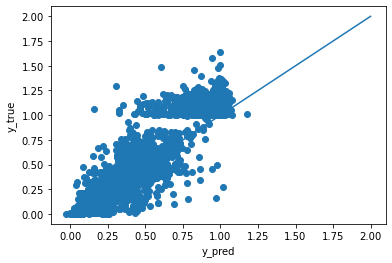

In [8]:
import matplotlib.pyplot as plt

plt.scatter(y_true,y_pred)
#plt.title('测试集活性值的预测值与真实值')
x = np.linspace(0, 2)
plt.plot(x, x)
plt.xlabel('y_pred')
plt.ylabel('y_true')
# plt.savefig

In [6]:
# 计算 Pearson r
y_true = df_allpred['Normalized_QM'].to_list()
y_pred = df_allpred['Pred_Norm_QM'].to_list()
PCC(y_true, y_pred)

0.9267466225335701

In [7]:
# 计算 tau
y_true = df_allpred['Normalized_QM'].to_list()
y_pred = df_allpred['Pred_Norm_QM'].to_list()
scipy.stats.kendalltau(y_pred, y_true)[0]

0.7200475522377997